11490434/11490434 [==============================] - 0s 0us/step
Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 2s 29us/sample - loss: 0.3848 - accuracy: 0.8961 - val_loss: 0.1749 - val_accuracy: 0.9538
Epoch 2/3
 2304/54000 [>.............................] - ETA: 1s - loss: 0.1939 - accuracy: 0.9427

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54000/54000 [==============================] - 2s 28us/sample - loss: 0.1728 - accuracy: 0.9499 - val_loss: 0.1206 - val_accuracy: 0.9668
Epoch 3/3
54000/54000 [==============================] - 2s 44us/sample - loss: 0.1246 - accuracy: 0.9639 - val_loss: 0.1048 - val_accuracy: 0.9705


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Точность на чистых данных: 96.53%
Точность на атакованных данных: 2.24%



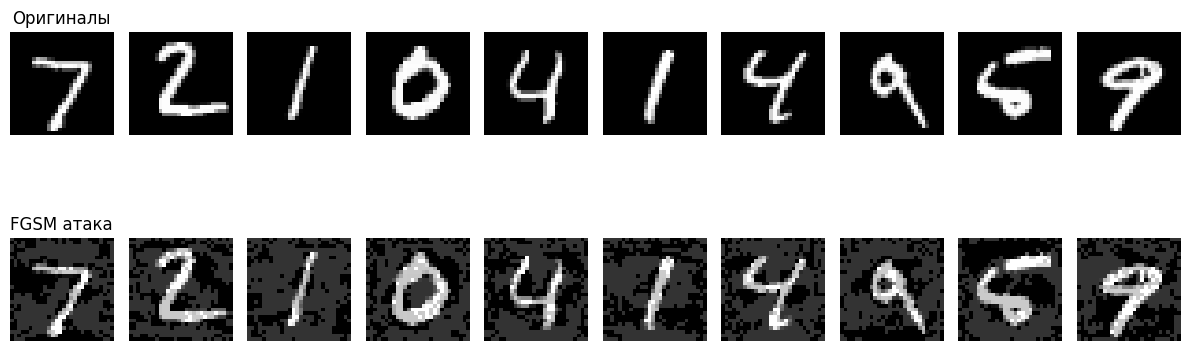

Train on 108000 samples, validate on 12000 samples
Epoch 1/3
108000/108000 [==============================] - 3s 32us/sample - loss: 0.2979 - accuracy: 0.9244 - val_loss: 0.1462 - val_accuracy: 0.9661
Epoch 2/3
108000/108000 [==============================] - 3s 31us/sample - loss: 0.1347 - accuracy: 0.9643 - val_loss: 0.1159 - val_accuracy: 0.9693
Epoch 3/3
108000/108000 [==============================] - 3s 26us/sample - loss: 0.0927 - accuracy: 0.9740 - val_loss: 0.0957 - val_accuracy: 0.9726

[ЗАЩИЩЕННАЯ МОДЕЛЬ]
Точность на чистых данных: 97.11%
Точность на атакованных данных: 96.84%

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Оригинальная модель (атакованные данные): 2.24%
Защищенная модель (атакованные данные): 96.84%
Улучшение: 0.9460


In [1]:
# Установка зависимостей
!pip install -U numpy==1.23.5 scikit-learn==1.1.3 tensorflow==2.12.0 adversarial-robustness-toolbox==1.14.0

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

# Отключение eager execution для совместимости с ART
tf.compat.v1.disable_eager_execution()

##########################################################################
### Загрузка и подготовка данных MNIST
def load_and_preprocess_data():
    """Загрузка и предобработка данных MNIST"""
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Нормализация изображений
    train_images = train_images.astype(np.float32) / 255.0
    test_images = test_images.astype(np.float32) / 255.0

    # Добавление размерности канала
    train_images = np.expand_dims(train_images, -1)
    test_images = np.expand_dims(test_images, -1)

    # Преобразование меток в one-hot кодировку
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels

# Загрузка данных
x_train, y_train, x_test, y_test = load_and_preprocess_data()

##########################################################################
### Создание и обучение модели
def create_simple_model(input_shape, num_classes):
    """Создание простой нейронной сети"""
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Создание и обучение модели
model = create_simple_model((28, 28, 1), 10)
model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

##########################################################################
### Атака FGSM
def perform_fgsm_attack(classifier, test_data, epsilon=0.2):
    """Выполнение атаки Fast Gradient Sign Method"""
    attack = FastGradientMethod(
        estimator=classifier,
        eps=epsilon
    )
    return attack.generate(x=test_data)

# Создание ART-классификатора
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Генерация атакованных изображений
x_test_adversarial = perform_fgsm_attack(classifier, x_test)

# Оценка модели на оригинальных и атакованных данных
_, clean_accuracy = model.evaluate(x_test, y_test, verbose=0)
_, adversarial_accuracy = model.evaluate(x_test_adversarial, y_test, verbose=0)

print("\n" + "="*50)
print(f"Точность на чистых данных: {clean_accuracy * 100:.2f}%")
print(f"Точность на атакованных данных: {adversarial_accuracy * 100:.2f}%")
print("="*50 + "\n")

##########################################################################
### Визуализация результатов атаки
def visualize_adversarial_examples(original, adversarial, num_samples=10):
    """Визуализация оригинальных и атакованных изображений"""
    plt.figure(figsize=(12, 5))

    for i in range(num_samples):
        # Оригинальное изображение
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Оригиналы")

        # Атакованное изображение
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(adversarial[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("FGSM атака")

    plt.tight_layout()
    plt.show()

# Визуализация примеров
visualize_adversarial_examples(x_test, x_test_adversarial)

##########################################################################
### Защита: Adversarial Training
def create_defended_model():
    """Создание и обучение защищенной модели"""
    # Генерация атакованных тренировочных данных
    attack_train = FastGradientMethod(estimator=classifier, eps=0.2)
    x_train_adversarial = attack_train.generate(x=x_train)

    # Объединение оригинальных и атакованных данных
    combined_data = np.concatenate([x_train, x_train_adversarial])
    combined_labels = np.concatenate([y_train, y_train])

    # Создание и обучение модели
    defended_model = create_simple_model((28, 28, 1), 10)
    defended_model.fit(
        combined_data, combined_labels,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
        verbose=1
    )
    return defended_model

# Создание защищенной модели
defended_model = create_defended_model()

# Оценка защищенной модели
_, clean_def_accuracy = defended_model.evaluate(x_test, y_test, verbose=0)
_, adv_def_accuracy = defended_model.evaluate(x_test_adversarial, y_test, verbose=0)

print("\n" + "="*50)
print("[ЗАЩИЩЕННАЯ МОДЕЛЬ]")
print(f"Точность на чистых данных: {clean_def_accuracy * 100:.2f}%")
print(f"Точность на атакованных данных: {adv_def_accuracy * 100:.2f}%")
print("="*50)

# Сравнение результатов
print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print(f"Оригинальная модель (атакованные данные): {adversarial_accuracy * 100:.2f}%")
print(f"Защищенная модель (атакованные данные): {adv_def_accuracy * 100:.2f}%")
print(f"Улучшение: {adv_def_accuracy - adversarial_accuracy:.4f}")
print("="*50)